In [1]:
import pyedflib
import numpy as np

In [25]:
import arrow

In [2]:
from datetime import datetime as dt
from datetime import timedelta as td

In [3]:
from bs4 import BeautifulSoup

In [4]:
import matplotlib.pyplot as plt

In [5]:
f = pyedflib.EdfReader('local-data/chat-baseline-300004.edf')

In [6]:
with open('./local-data/chat-baseline-300004-nsrr.xml') as fp:
    annot = BeautifulSoup(fp)

In [7]:
f.samplefrequency(51)

200.00000000000003

In [8]:
f.getFileDuration()

37545

In [26]:
start_dt = arrow.get(f.getStartdatetime())
start_dt

<Arrow [1985-01-01T19:53:10+00:00]>

In [27]:
start_dt.shift(seconds=37545)

<Arrow [1985-01-02T06:18:55+00:00]>

In [10]:
# Uncomment to see the signal details
#f.getSignalHeaders()

In [11]:
# This is how you cleanup the f object
#f._close()
#del f

In [12]:
n = f.signals_in_file
n

52

In [13]:
def read_edf_signals(f, signals):
    labels = f.getSignalLabels()
    indices = [labels.index(signal) for signal in signals]
    sigbufs = np.zeros((len(signals), f.getNSamples()[0]))
    for i, signal_index in enumerate(indices):
        print(f"read {i} from {signal_index}")
        sigbufs[i, :] = f.readSignal(signal_index)
    f._close()
    return sigbufs

In [14]:
def read_edf_signals_file(filename, signals):
    f = pyedflib.EdfReader(filename)
    return read_edf_signals(f, signals)

In [19]:
def read_sleep_stages(total_duration, scored_events):
    #print(len(scored_events))
    stages = np.zeros(total_duration)
    for event in scored_events:
        event_type = event.eventtype.text.split('|')[0]
        if event_type == 'Stages':
            #print('type:', event_type)
            #print('concept:', event.eventconcept.text)
            #print('start:', event.start.text)
            #print('duration:', event.duration.text)
            concept = event.eventconcept.text.split('|')
            stage = concept[0]
            stage_no = int(concept[1])
            start = int(float(event.start.text))
            duration = int(float(event.duration.text))
            stages[start:start+duration] = stage_no
    return stages

In [21]:
annot_duration = int(float(annot.scoredevents.scoredevent.duration.text))
annot_duration

37545

In [15]:
sigs = read_edf_signals(f, ['ABD', 'Chest', 'SAO2'])
#sigs = read_edf_signals_file('local-data/chat-baseline-300004.edf', ['ABD', 'Chest', 'SAO2'])

read 0 from 34
read 1 from 33
read 2 from 49


In [22]:
stages = read_sleep_stages(annot_duration, annot.scoredevents.find_all('scoredevent'))

In [16]:
sigs.shape

(3, 7509000)

In [56]:
from scipy.signal import hilbert

In [65]:
x1 = sigs[0,:]
x2 = sigs[1,:]
x1_h = hilbert(x1)
x2_h = hilbert(x2)
x1_r = np.real(x1_h)
x1_i = np.imag(x1_h)
x2_r = np.real(x2_h)
x2_i = np.imag(x2_h)

In [66]:
x1_r.dtype, x1_i.dtype

(dtype('float64'), dtype('float64'))

In [67]:
#numer = x1*x2_h - x2*x1_h
#denom = x1*x2 + x1_h*x2_h

numer = x1_r*x2_i - x2_r*x1_i
denom = x1_r*x2_r + x1_i*x2_i
taa = np.arctan2(numer, denom)

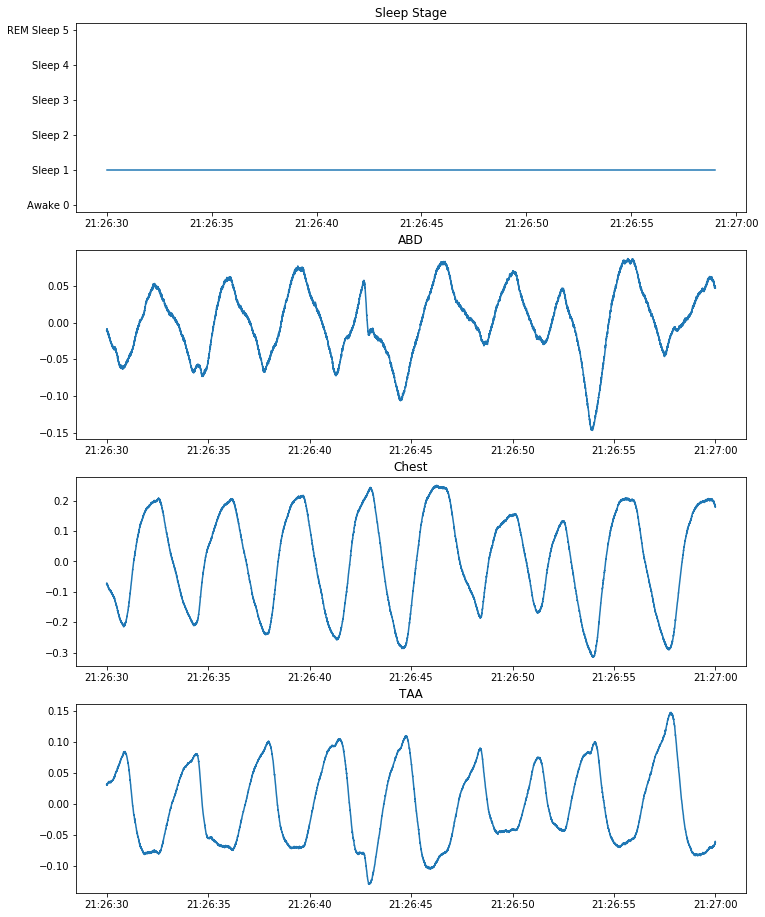

In [74]:
plt.figure(figsize=(12,16))
freq = 200
window_len = 30
start_time = 8_200
start_time = 5_600
plot_range = np.arange(start_time*freq, (start_time+window_len)*freq)

time_range = np.empty_like(plot_range, dtype='datetime64[ms]')
for i in range(len(plot_range)):
    time_range[i] = start_dt.naive + td(milliseconds=plot_range[i]*1/freq*1000)

# sleep stage is different resolution
ss_time_range = np.empty(window_len, dtype='datetime64[ms]')
for i in range(window_len):
    ss_time_range[i] = start_dt.naive + td(seconds=start_time+i)
    
    
plt.subplot(411)
plt.title('Sleep Stage')
plt.ylim((-0.2,5.2))
plt.yticks(range(6), ['Awake 0', 'Sleep 1', 'Sleep 2', 'Sleep 3', 'Sleep 4', 'REM Sleep 5'])
plt.plot(ss_time_range, stages[start_time:start_time+window_len])

plt.subplot(412)
plt.title('ABD')
plt.plot(time_range, sigs[0,plot_range])
plt.subplot(413)
plt.title('Chest')
plt.plot(time_range, sigs[1,plot_range])
plt.subplot(414)
plt.title('TAA')
plt.plot(time_range, taa[plot_range])



#plt.title('SAO2')
#plt.plot(time_range, sigs[2,plot_range])


In [21]:
signal_labels = f.getSignalLabels()
list(zip(signal_labels, range(len(signal_labels))))

[('Event', 0),
 ('C3', 1),
 ('C4', 2),
 ('O1', 3),
 ('O2', 4),
 ('M1', 5),
 ('M2', 6),
 ('Cchin', 7),
 ('F3', 8),
 ('F4', 9),
 ('F7', 10),
 ('F8', 11),
 ('Fz', 12),
 ('Fp1', 13),
 ('Fp2', 14),
 ('Fpz', 15),
 ('P3', 16),
 ('P4', 17),
 ('ECG3', 18),
 ('T3', 19),
 ('T4', 20),
 ('T5', 21),
 ('T6', 22),
 ('E1', 23),
 ('E2', 24),
 ('Lchin', 25),
 ('Rchin', 26),
 ('ECG2', 27),
 ('ECG1', 28),
 ('Lleg1', 29),
 ('Lleg2', 30),
 ('Rleg1', 31),
 ('Rleg2', 32),
 ('Chest', 33),
 ('ABD', 34),
 ('Airflow', 35),
 ('Snore', 36),
 ('CannulaFlow', 37),
 ('SUM', 38),
 ('Position', 39),
 ('DC2', 40),
 ('DC3', 41),
 ('DC4', 42),
 ('CPress', 43),
 ('CFlow', 44),
 ('Cap', 45),
 ('EtCO2', 46),
 ('EXTSAT', 47),
 ('Pleth', 48),
 ('SAO2', 49),
 ('PR', 50),
 ('DHR', 51)]

In [22]:
f.getNSamples()

array([7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000])